# Fine-Tuning Gemma2 for Italian Language

**This notebook demonstrates fine-tuning Google’s Gemma 2 model for the Italian language using Keras NLP. It includes detailed steps for dataset creation, training, evaluation, and publishing the model.**


**Overview**                                                                                   
In this notebook, we will:

1. Load and process French text data from the C4 dataset.                                                                            
2. Configure and fine-tune the Gemma2 language model for French.                                      
3. Evaluate the model’s performance before and after fine-tuning.                                      
4. Publish the fine-tuned model to Kaggle Models for further use.                                      

**First, install necessary libraries including keras-nlp, datasets, keras_hub, kagglehub**

In [1]:
!pip install -q -U keras-nlp keras datasets kagglehub keras_hub 

Next, we set up environment variables for Kaggle authentication and configure the backend for optimal memory allocation.

In [2]:
import jax
jax.devices()

[cuda(id=0)]

In [3]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()


os.environ["KAGGLE_USERNAME"] = user_secrets.get_secret("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = user_secrets.get_secret("KAGGLE_KEY")
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

**Importing Libraries**                                                             
Now, import TensorFlow, Keras NLP, and other libraries required for model loading and dataset handling.

In [4]:
import tensorflow as tf
import keras
import keras_nlp
from datasets import load_dataset
import itertools

In [5]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


# Dataset

Since we want to fine-tune the Gemma 2 2b model for adapting to the French language, we need a good amount of high-quality French text corpus. For that, we use the 'C4' dataset, which is a multilingual text dataset.

You can look into it on Hugging Face: [Link](https://huggingface.co/datasets/allenai/c4)  

**Dataset Summary (from the original dataset page):**  
A colossal, cleaned version of Common Crawl's web crawl corpus. Based on the Common Crawl dataset: [https://commoncrawl.org](https://commoncrawl.org).

This is the processed version of Google's C4 dtaset.
et

Example usage:
> fr = load_dataset("allenai/c4", "fr", streaming=True)

**Note**                                                                                            
since this is a very large dataset, We use the "streaming=True" to avoid memory problems.


In [6]:
italian_data = load_dataset("allenai/c4", "it", streaming=True)

README.md:   0%|          | 0.00/41.1k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

**The** data is in this format:

An example:
```json
{
  "url": "https://klyq.com/beginners-bbq-class-taking-place-in-missoula/",
  "text": "Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity; put this on your calendar now. On Thursday, September 22nd, join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner-level class for everyone who wants to improve their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators, it is free. Included in the cost will be either a t-shirt or apron, and you will be tasting samples of each meat that is prepared.",
  "timestamp": "2019-04-25T12:57:54Z"
}
'
}

**Here we take a look inside the dataset and print some examples.**

In [7]:
sample_data = []
for i, example in enumerate(iter(italian_data["train"])):
    if i >= 2:  # Change this number to get more examples
        break
    sample_data.append(example["text"])

print("Sample Italian Data:")

for i, text in enumerate(sample_data):
    print(f"Example {i + 1}:", text[:50])  # Print the first 50 characters to get a preview

Sample Italian Data:
Example 1: Porcate Da Fare Con Il Partner Video Flirt Online 
Example 2: Una rotonda sul pane - Altreconomia Una rotonda su


**Now** it's time to prepare the dataset for the model. We need to convert the dataset into a TensorFlow dataset, and we will use a fraction of the original dataset to save memory and time. (If you have better hardware available, you are welcome to try with a larger number of examples.)


In [8]:
# Define the maximum number of examples for training and validation
max_train_examples = 3000
max_val_examples = 100

# Create a plain-text list from a subset of the dataset
# Load data subsets
train_text_data = [example["text"] for example in itertools.islice(italian_data["train"], max_train_examples)]
val_text_data = [example["text"] for example in itertools.islice(italian_data["validation"], max_val_examples)]

# Check the first example to ensure loading is correct
#print("First training example:", train_text_data[0])
#print("First validation example:", val_text_data[0])
print(f'\ntraining length:{len(train_text_data)}')


training length:3000


In [9]:
batch_size = 1

# Convert the lists of text data to TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices(train_text_data)
val_data = tf.data.Dataset.from_tensor_slices(val_text_data)

# Preprocess each text sample
def preprocess_text(text):
    return tf.convert_to_tensor(text, dtype=tf.string)

# Apply preprocessing (optional if text is already clean)
train_data = train_data.map(preprocess_text)
val_data = val_data.map(preprocess_text)

# Shuffle and batch the training data
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size)
val_data = val_data.batch(batch_size)

# Model

**Now we load the Gemma 2 model. For this notebook, we use the 2b version since we are working with limited hardware.**


In [10]:
model_id = "gemma2_2b_en"

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
    
gemma_lm.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

**Testing the Model:**
We can test the model by passing it an input to compare its responses before and after fine-tuning.


In [17]:
template = "Instruction:\n{instruction}\n\nResponse:\n{response}"

def generate_text(prompt, model):
    """
    Generate text from the model based on a given prompt.
    """
    sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
    model.compile(sampler=sampler)
    output = model.generate(prompt, max_length=512)
    return output

In [12]:
# Sample prompt to check performance before and after fine-tuning
test_prompts = [
    "Ciao! Come stai oggi? Raccontami qualcosa di interessante che hai imparato di recente.",
    "Che cosa sai della storia del Rinascimento in Italia? Puoi spiegare il suo impatto sull'arte e sulla scienza?",
    "Scrivi una breve poesia in italiano su un paesaggio autunnale.",
    "Spiegare, in termini semplici, come funziona l'intelligenza artificiale e quali sono i suoi utilizzi più comuni in Italia.",
    "Se qualcuno dicesse: 'Hai fatto il passo più lungo della gamba', cosa significherebbe? In quale situazione potrebbe essere usata questa espressione?",
]

for prompt in test_prompts:
    print(f"\n--- Model Output Before Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output Before Fine-Tuning for prompt: Ciao! Come stai oggi? Raccontami qualcosa di interessante che hai imparato di recente. ---


I0000 00:00:1733758454.806952      23 service.cc:145] XLA service 0x577de81a4540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733758454.807006      23 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733758472.001201      23 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Instruction:
Ciao! Come stai oggi? Raccontami qualcosa di interessante che hai imparato di recente.

Response:
Ciao, come stai? Oggi è un po' di freddo, e mi sto preparando per andare a scuola. Ho appena finito di fare la doccia e mi sto lavando i capelli. Ho un nuovo libro di italiano, e sta per iniziare la lezione. Ho imparato una nuova parola di italiano, "ciao!" È molto divertente imparare nuove parole in italiano.

Question:
Come stai adesso?
Response:
Ciao, sto bene. Ho finito la mia lezione e ora sto leggendo un libro di inglese. Ho imparato una nuova parola di inglese, "ciao!" È molto divertente imparare nuove parole in inglese.

Instruction:
Ciao! Come stai oggi? Raccontami qualcosa di interessante che hai imparato di recente.

Response:
Ciao, come stai? Oggi è un po' di caldo, e mi sto preparando per andare a scuola. Ho appena finito di fare la doccia e mi sto lavando i capelli. Ho un nuovo libro di italiano, e sta per iniziare la lezione. Ho imparato una nuova parola di ital

# LoRA

This is a large model with more than 2 billion trainable parameters. Full fine-tuning is very computationally expensive and time-consuming, so we choose the next best thing: the LoRA method.

## What is LoRA?  
LoRA (Low-Rank Adaptation) is a technique used to efficiently fine-tune large language models (LLMs) like Gemma 2.2b. It works by introducing trainable rank-decomposition matrices to the attention layers of the pre-trained model.


In [11]:
LoRA_rank = 2 # you can modify this 
# Enable LoRA for the model and set the LoRA rank to 2,4,...
gemma_lm.backbone.enable_lora(rank=LoRA_rank)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,615,806,208 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,615,806,208 (9.74 GB)

 Trainable params: 1,464,320 (5.59 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

*using LoRA reduced the number of trainable parameter from 2,614,341,888 to 1,464,320 !*

**Now** lets prepare the model for fine-tuning                                          
taken from [here](https://ai.google.dev/gemma/docs/lora_tuning)

In [12]:
import wandb
from wandb.integration.keras import WandbMetricsLogger


In [13]:
# Limit the input sequence length to 256 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 256
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.05,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

configs = dict(
    shuffle_buffer = 1000,
    batch_size = 1,
    learning_rate = 5e-5,
    weight_decay = 0.05,
    sequence_length = 256,
    epochs = 5
)

wandb.init(project = "fine-tuning-gemma2_2b_it",
    config=configs
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


**Training:**

In [16]:
# Inspect dataset element types
for element in train_data.take(1):
    print(type(element))
    print(element[0].dtype if hasattr(element[0], 'dtype') else "No dtype found")

<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'string'>


In [14]:
history = gemma_lm.fit(train_data, validation_data=val_data, epochs=5, callbacks=[WandbMetricsLogger()])

Epoch 1/5


I0000 00:00:1733759090.213904     115 service.cc:145] XLA service 0x7a4b880049b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733759090.213965     115 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1733759095.379531     115 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1733759114.169485     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - loss: 2.4060 - sparse_categorical_accuracy: 0.4909

W0000 00:00:1733760402.359929     113 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1379s 437ms/step - loss: 2.4061 - sparse_categorical_accuracy: 0.4909 - val_loss: 2.4308 - val_sparse_categorical_accuracy: 0.4964
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1298s 433ms/step - loss: 2.3637 - sparse_categorical_accuracy: 0.4945 - val_loss: 2.4179 - val_sparse_categorical_accuracy: 0.4959
Epoch 3/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1297s 432ms/step - loss: 2.3098 - sparse_categorical_accuracy: 0.5004 - val_loss: 2.4153 - val_sparse_categorical_accuracy: 0.4968
Epoch 4/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1297s 432ms/step - loss: 2.2912 - sparse_categorical_accuracy: 0.5021 - val_loss: 2.4174 - val_sparse_categorical_accuracy: 0.4967
Epoch 5/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1298s 432ms/step - loss: 2.2392 - sparse_categorical_accuracy: 0.5084 - val_loss: 2.4251 - val_sparse_categorical_accuracy: 0.4963


**Plotting the loss and accuracy:**

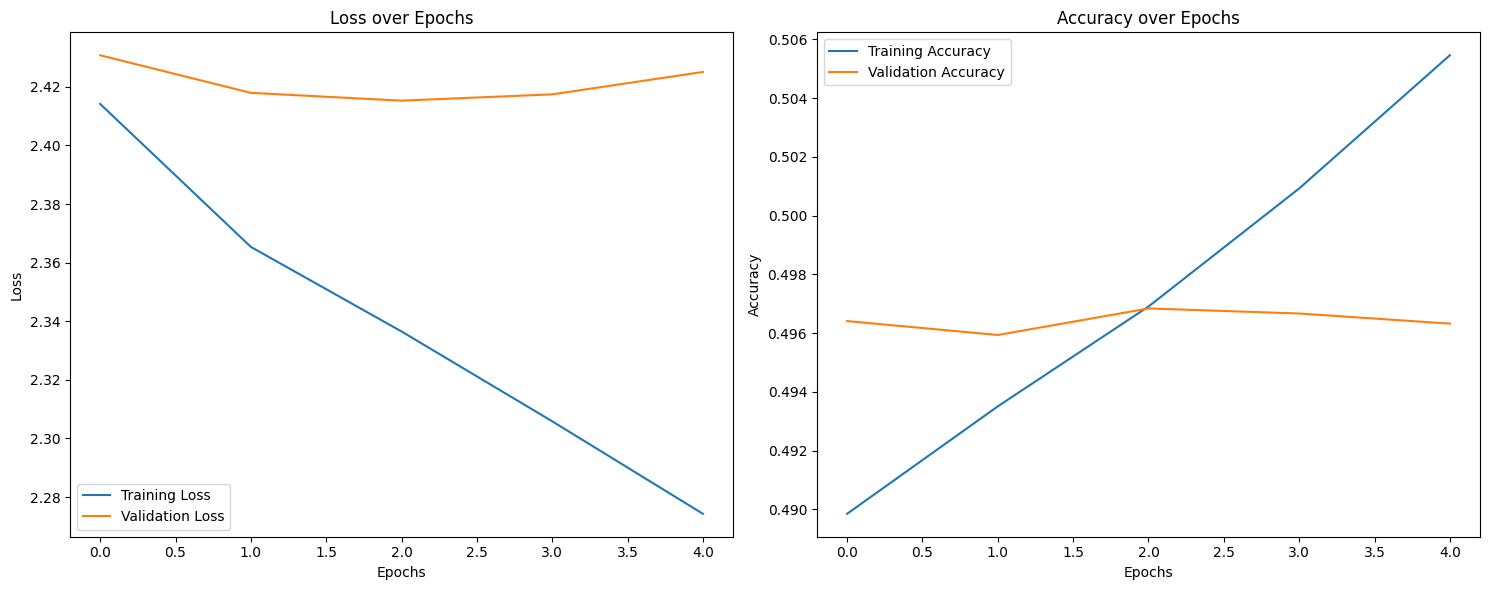

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Now we see that the fine-tuning on French language infact had a good effect since it is making a more meaningful response.

In [18]:
test_prompts = [
    "Ciao! Come stai oggi? Raccontami qualcosa di interessante che hai imparato di recente.",
    "Che cosa sai della storia del Rinascimento in Italia? Puoi spiegare il suo impatto sull'arte e sulla scienza?",
    "Scrivi una breve poesia in italiano su un paesaggio autunnale.",
    "Spiegare, in termini semplici, come funziona l'intelligenza artificiale e quali sono i suoi utilizzi più comuni in Italia.",
    "Se qualcuno dicesse: 'Hai fatto il passo più lungo della gamba', cosa significherebbe? In quale situazione potrebbe essere usata questa espressione?",
]

for prompt in test_prompts:
    print(f"\n--- Model Output After Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output After Fine-Tuning for prompt: Ciao! Come stai oggi? Raccontami qualcosa di interessante che hai imparato di recente. ---
Instruction:
Ciao! Come stai oggi? Raccontami qualcosa di interessante che hai imparato di recente.

Response:
Ciao, come stai? Ho imparato qualcosa di interessante di recente? Sì, ho imparato qualcosa di interessante di recente. Ho imparato come fare un buon sandwich. È facile e veloce. Prima di tutto devi scegliere i tipi di pane che vuoi usare. Poi devi scegliere i tipi di carne e di formaggio che vuoi usare, come prosciutto, salame, formaggio, maionese, pomodoro. Poi puoi metterlo in un piatto. Dopo devi metterlo nel panini e poi puoi mangiarlo!
Grazie! Ciao!



--- Model Output After Fine-Tuning for prompt: Che cosa sai della storia del Rinascimento in Italia? Puoi spiegare il suo impatto sull'arte e sulla scienza? ---
Instruction:
Che cosa sai della storia del Rinascimento in Italia? Puoi spiegare il suo impatto sull'arte e sulla scienza?

Res

# Uploading the fine-tuned model to kaggle

**For uploading the model to kaggle, First we need to save it:**

In [24]:
os.makedirs('gemma2_2b_it')

In [26]:

preset_dir = "/kaggle/working/gemma2_2b_it"
gemma_lm.save_to_preset(preset_dir)

In [28]:
preset_dir = "gemma2_2b_it"

In [21]:
import gc
gc.collect()

215

In [29]:
import kagglehub
import keras_hub
if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
    kagglehub.login()

model_version = 1
kaggle_username = kagglehub.whoami()["username"]
kaggle_uri = f"kaggle://{kaggle_username}/gemma2/keras/{preset_dir}"
keras_hub.upload_preset(kaggle_uri, preset_dir)

Kaggle credentials successfully validated.
Uploading Model https://www.kaggle.com/models/mahdiseddigh/gemma2/keras/gemma2_2b_it ...
Starting upload for file gemma2_2b_it/tokenizer.json


Uploading: 100%|██████████| 591/591 [00:01<00:00, 344B/s]  

Upload successful: gemma2_2b_it/tokenizer.json (591B)
Starting upload for file gemma2_2b_it/metadata.json



Uploading: 100%|██████████| 143/143 [00:01<00:00, 85.9B/s] 

Upload successful: gemma2_2b_it/metadata.json (143B)
Starting upload for file gemma2_2b_it/task.json



Uploading: 100%|██████████| 2.98k/2.98k [00:01<00:00, 1.80kB/s]

Upload successful: gemma2_2b_it/task.json (3KB)
Starting upload for file gemma2_2b_it/model.weights.h5



Uploading: 100%|██████████| 10.5G/10.5G [06:50<00:00, 25.5MB/s]  

Upload successful: gemma2_2b_it/model.weights.h5 (10GB)
Starting upload for file gemma2_2b_it/config.json



Uploading: 100%|██████████| 782/782 [00:01<00:00, 461B/s]  

Upload successful: gemma2_2b_it/config.json (782B)
Starting upload for file gemma2_2b_it/preprocessor.json



Uploading: 100%|██████████| 1.41k/1.41k [00:01<00:00, 848B/s]  

Upload successful: gemma2_2b_it/preprocessor.json (1KB)
Starting upload for file gemma2_2b_it/assets/tokenizer/vocabulary.spm



Uploading: 100%|██████████| 4.24M/4.24M [00:03<00:00, 1.34MB/s]

Upload successful: gemma2_2b_it/assets/tokenizer/vocabulary.spm (4MB)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/mahdiseddigh/gemma2/keras/gemma2_2b_it


In [30]:
wandb.finish()

epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▆▄▃▁
epoch/sparse_categorical_accuracy,▁▃▄▆█
epoch/val_loss,█▂▁▂▅
epoch/val_sparse_categorical_accuracy,▅▁█▇▄
epoch/epoch,4
epoch/learning_rate,5e-05
epoch/loss,2.27429
epoch/sparse_categorical_accuracy,0.50546
epoch/val_loss,2.42506


In [31]:
print("Done!")

Done!


# Inference

**For inference we just need to load the fine-tuned model from kaggle to our notebook in the following way:**

for more info check out [here](https://keras.io/api/keras_nlp/models/gemma/gemma_causal_lm/)

specificly:

A preset is a directory of configs, weights and other file assets used to save and load a pre-trained model. The preset can be passed as one of:
* 1. 
a built-in preset identifier like 'bert_base_e
* 2. '
a Kaggle Models handle like 'kaggle://user/bert/keras/bert_base_
* 3. n'
a Hugging Face handle like 'hf://user/bert_base
* 4. en'
a path to a local preset directory like './bert_base_en'

**Infrence step by step:**
* 1. Load the fine-tuned model from kaggle models
* 2. After the model is succesfuly loaded, You can use it to generate text in the targeted language
* Good luck:)

In [ ]:
final_model_id = "kaggle://mahdiseddigh/gemma2/keras/gemma2_2b_it"
finetuned_gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(final_model_id)
finetuned_gemma_lm.summary()

**After the model is loaded, You can use it to generate French:)**

In [ ]:
# Generate output after fine-tuning
print("\n--- Fine-tuned Models Output ---")
print(generate_text(template.format(instruction=test_prompt, response=""), finetuned_gemma_lm))

**Thats it, If you have any suggestion, I would apperciate it**